
Projeto: Detecção de Diabetes com Machine Learning

Autor: Lucas de Souza Lima

Descrição: Este script realiza pré-processamento, modelagem e avaliação de modelos
           (XGBoost e Random Forest) para detecção de diabetes.



In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Carregar dados
df = pd.read_csv("diabetes_prediction_dataset.csv")

# Renomear colunas para português
df.columns = ["Gênero","Idade","Hipertensão","Doenca_cardiaca","Historico_fumante",
              "IMC","Nivel_HbA1c","nivel_glicose_sangue","diabetes"]

# Substituir valores categóricos para português
df['Gênero'] = df['Gênero'].replace({"Female": "Feminino", "Male": "Masculino", "Other": "Outro"})
df['Historico_fumante'] = df['Historico_fumante'].replace({
    "never": "nunca",
    "No Info": "s/ inform.",
    "current": "fumante",
    "former": "ex-fum",
    "ever": "já fumou",
    "not current": "não fuma atualmente"
})

# Remover duplicatas
df = df.drop_duplicates()

# Remover registros com gênero 'Outro' (poucos casos)
df = df[df['Gênero'] != 'Outro']

# Verificar dados ausentes
print(df.isnull().sum())


Gênero                  0
Idade                   0
Hipertensão             0
Doenca_cardiaca         0
Historico_fumante       0
IMC                     0
Nivel_HbA1c             0
nivel_glicose_sangue    0
diabetes                0
dtype: int64


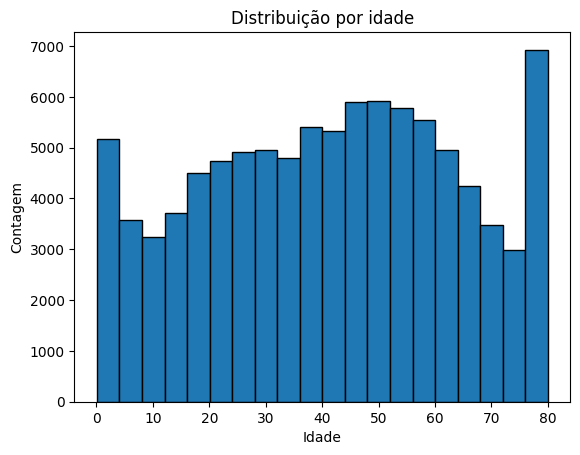

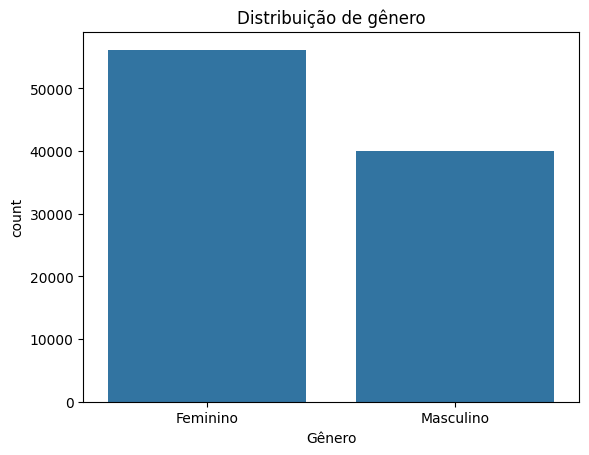

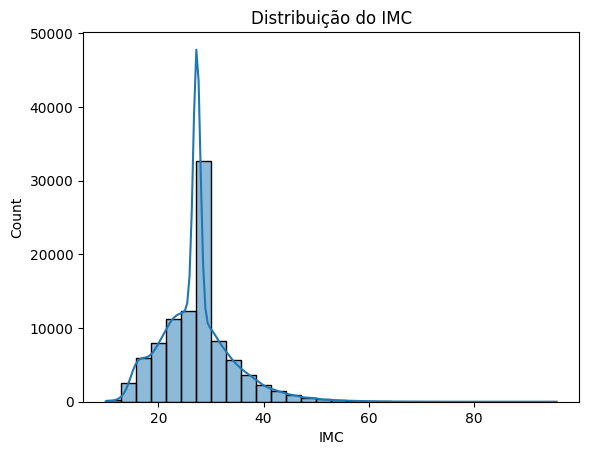

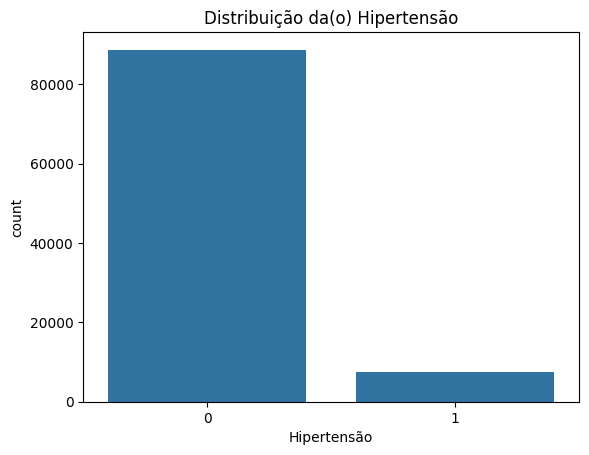

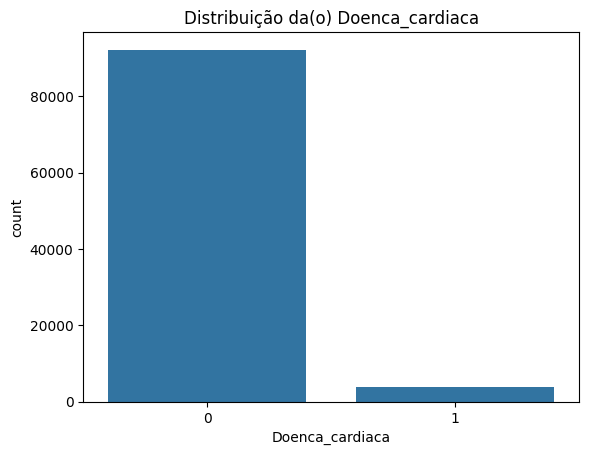

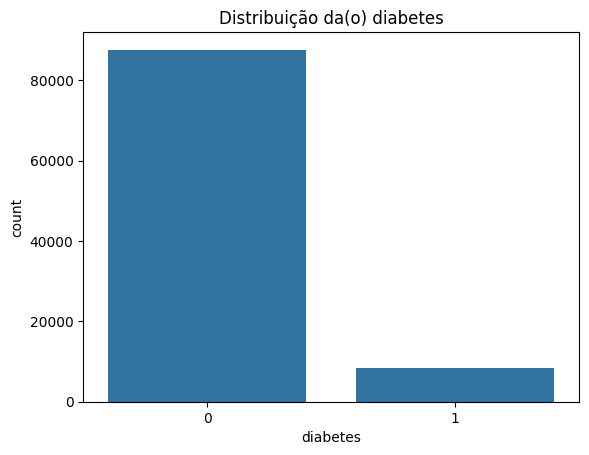

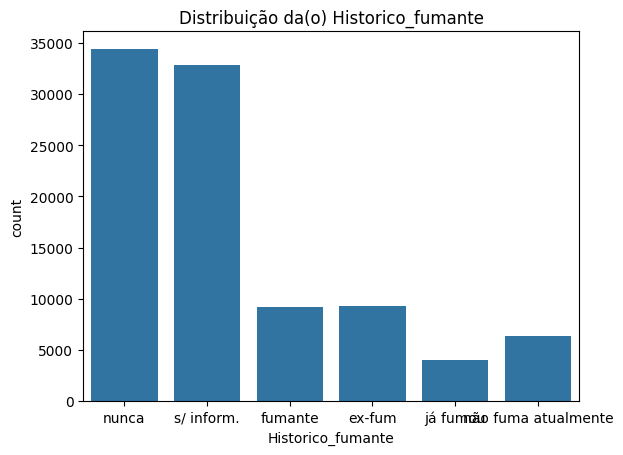

In [8]:
# Histograma da idade
plt.hist(df['Idade'], bins=20, edgecolor='black')
plt.title('Distribuição por idade')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()

# Distribuição de gênero
sns.countplot(x='Gênero', data=df)
plt.title('Distribuição de gênero')
plt.show()

# Distribuição do IMC
sns.histplot(df['IMC'], bins=30, kde=True)
plt.title('Distribuição do IMC')
plt.show()

# Distribuição de variáveis categóricas
for col in ['Hipertensão', 'Doenca_cardiaca', 'diabetes', 'Historico_fumante']:
    sns.countplot(x=col, data=df)
    plt.title(f'Distribuição da(o) {col}')
    plt.show()


In [9]:
# Agrupar categorias de fumantes para simplificar
def combinando_fumantes(estado):
    if estado in ["nunca", "s/ inform."]:
        return 'não-fumante'
    elif estado == 'fumante':
        return "fumante"
    elif estado in ['ex-fum', 'já fumou', 'não fuma atualmente']:
        return "ex-fumante"

df['Historico_fumante'] = df['Historico_fumante'].apply(combinando_fumantes)

# Codificação das variáveis categóricas
le_genero = LabelEncoder()
le_fumante = LabelEncoder()

df['Gênero'] = le_genero.fit_transform(df['Gênero'])
df['Historico_fumante'] = le_fumante.fit_transform(df['Historico_fumante'])

# Separar features e target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Dividir treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcular scale_pos_weight para balancear classes
neg = sum(y_train == 0)
pos = sum(y_train == 1)
scale_pos_weight = neg / pos if pos != 0 else 1
print(f"scale_pos_weight: {scale_pos_weight}")


scale_pos_weight: 10.340805190974782


In [10]:
# XGBoost
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 350,
    'scale_pos_weight': scale_pos_weight,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}
model_xgb = xgb.XGBClassifier(**params)
model_xgb.fit(X_train, y_train)

# Random Forest
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)
model_rf.fit(X_train, y_train)


/home/lslima/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=42)

Relatório de classificação - XGBoost
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     17525
           1       0.48      0.92      0.63      1701

    accuracy                           0.90     19226
   macro avg       0.73      0.91      0.79     19226
weighted avg       0.95      0.90      0.92     19226

AUC ROC - XGBoost: 0.9778


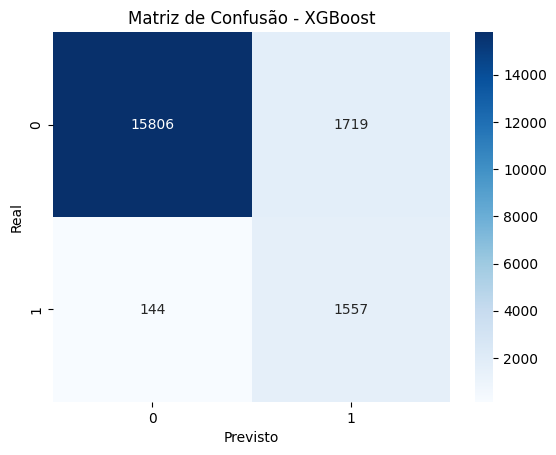

Relatório de classificação - Random Forest
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     17525
           1       0.46      0.90      0.61      1701

    accuracy                           0.90     19226
   macro avg       0.73      0.90      0.78     19226
weighted avg       0.94      0.90      0.91     19226

AUC ROC - Random Forest: 0.9726


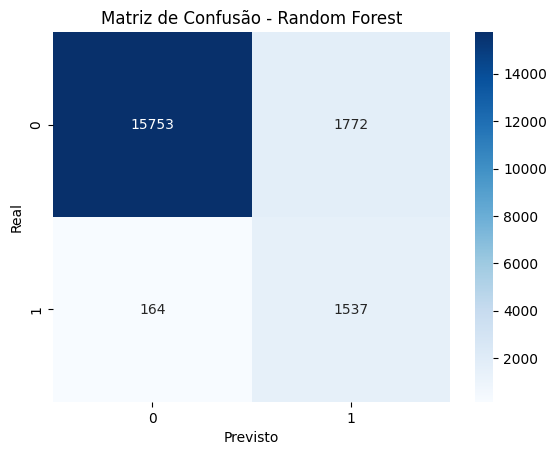

In [11]:
def avaliar_modelo(model, X_test, y_test, nome_modelo):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"Relatório de classificação - {nome_modelo}")
    print(classification_report(y_test, y_pred))
    print(f"AUC ROC - {nome_modelo}: {roc_auc_score(y_test, y_proba):.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

avaliar_modelo(model_xgb, X_test, y_test, 'XGBoost')
avaliar_modelo(model_rf, X_test, y_test, 'Random Forest')


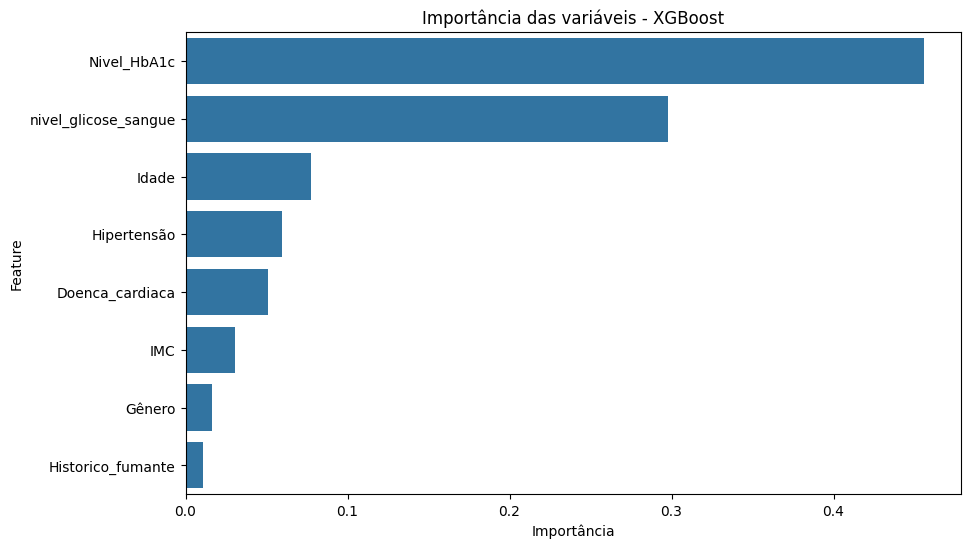

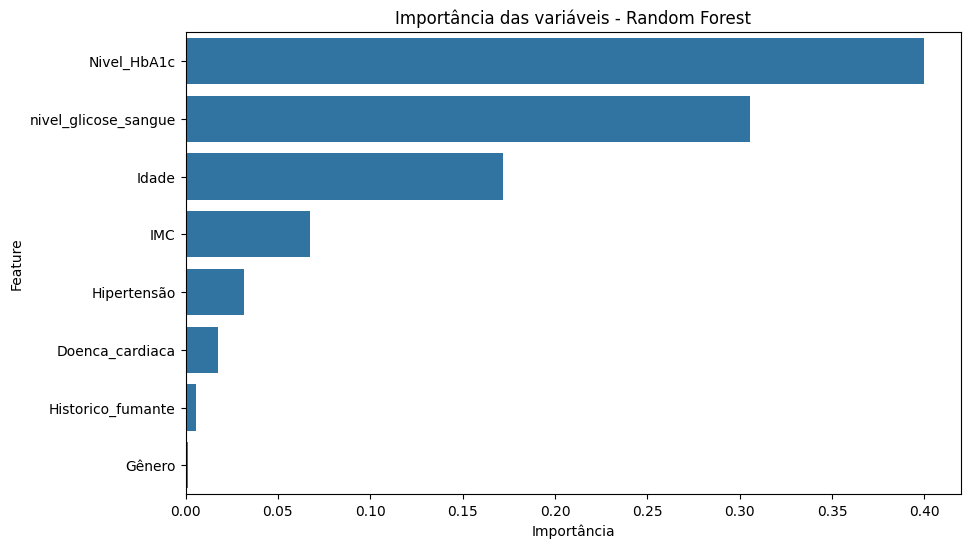

In [12]:
def plotar_importancia(model, features, nome_modelo):
    importancias = model.feature_importances_
    df_imp = pd.DataFrame({'Feature': features, 'Importância': importancias})
    df_imp = df_imp.sort_values(by='Importância', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importância', y='Feature', data=df_imp)
    plt.title(f'Importância das variáveis - {nome_modelo}')
    plt.show()

plotar_importancia(model_xgb, X.columns, 'XGBoost')
plotar_importancia(model_rf, X.columns, 'Random Forest')
